In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import time
from pathlib import Path
import itk
import matplotlib.pyplot as plt
import numpy as np
import torch
from camera_picture_viewer import Camera_picture_viewer
from correction_matrix_producer import Correction_matrix_producer
from getprofile import Get_profile
from image_loader import Image_loader
from letcorrection3D import letcorrection
from reconstructor import Reconstructor
# %aimport reconstructor
from tomograpic_viewer import Tomograpic_viewer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Prints the index of the current device
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the GPU device

True
0
2
Tesla V100-SXM2-32GB


In [3]:
start_time = time.time()
# for online readout (Basler 60gm =0.0634 | pixelfly = 0.073825)
# s = 0.0634  # Basler --- Resolution (mm/pixel) depends on camera
s = 0.073825  # Pixelfly --- Resolution (mm/pixel) depends on camera
directory = "../pictures/online/input/"
list_of_files = glob.glob(
    directory + "*"
)  # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
path_obj = Path(latest_file)
picture_name = path_obj.name

print(picture_name)
# ==================== Input Values ============================================
"""Check if spatial resolution s is put in correctly"""
ROI_diam = 2.5  # Diameter for the evaluated Region in mm (mask)
ROI_diam_sum = 2.5  # Diameter for the evaluated summed up Region (mask)
max_err = 0.05  # Reconstruction stops if relative Error is lower than this value
max_it = 4  # Maximum number of Iterations if Error threshold is not achieved
# it tends to get worse after the 4th or 5th iteration
ring_error = False
num_rings = 15
# Define path for measured pictures
path_pic_front = directory + picture_name
path_pic_top = directory + picture_name
path_pic_120 = directory + picture_name
path_pic_240 = directory + picture_name

# ROI definition
shape_front = (150, 110)
shape_side = (310, 110)
deltaz = 310
rot_angle = 0
x_0 = 5
y_0 = 0
y1_front = 195
y2_front = 345
x1_front = 633
x2_front = 743
y1_top = 447
y2_top = 757
x1_top = 633
x2_top = 743
y1_120 = 442
y2_120 = 752
x1_120 = 902
x2_120 = 1012
y1_240 = 442
y2_240 = 752
x1_240 = 374
x2_240 = 484

shift_image_front = torch.tensor([0, 0], dtype=torch.int)
shift_image_top = torch.tensor([0, 0], dtype=torch.int)
shift_image_120 = torch.tensor([0, 0], dtype=torch.int)
shift_image_240 = torch.tensor([0, 0], dtype=torch.int)

processed_Set_4_00024.tif


### Load Images

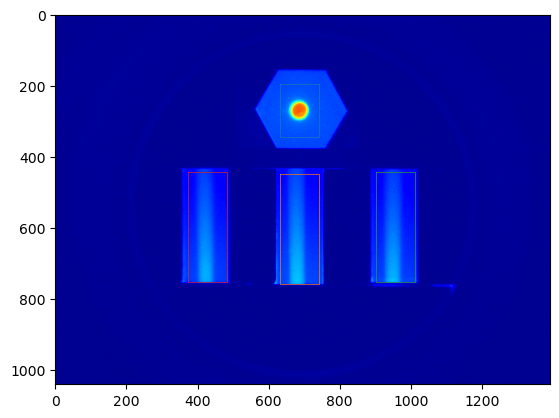

In [4]:
color_channel = "grey"

cam_pic_front = Image_loader(
    path_pic_front,
    color_channel,
    None,
    None,
    rot_angle,
    [y1_front, y2_front, x1_front, x2_front],
    None,
    None,
    shift_image_front,
    False,
    10 / 9,
    device,
).image  # DELTAX,DELTAY SHIFTING
cam_pic_top = Image_loader(
    path_pic_top,
    color_channel,
    None,
    None,
    rot_angle,
    [y1_top, y2_top, x1_top, x2_top],
    None,
    None,
    shift_image_top,
    False,
    1,
    device,
).image
cam_pic_120 = Image_loader(
    path_pic_120,
    color_channel,
    None,
    None,
    rot_angle,
    [y1_120, y2_120, x1_120, x2_120],
    None,
    None,
    shift_image_120,
    False,
    10 / 9,
    device,
).image
cam_pic_240 = Image_loader(
    path_pic_240,
    color_channel,
    None,
    None,
    rot_angle,
    [y1_240, y2_240, x1_240, x2_240],
    None,
    None,
    shift_image_240,
    False,
    10 / 9,
    device,
).image

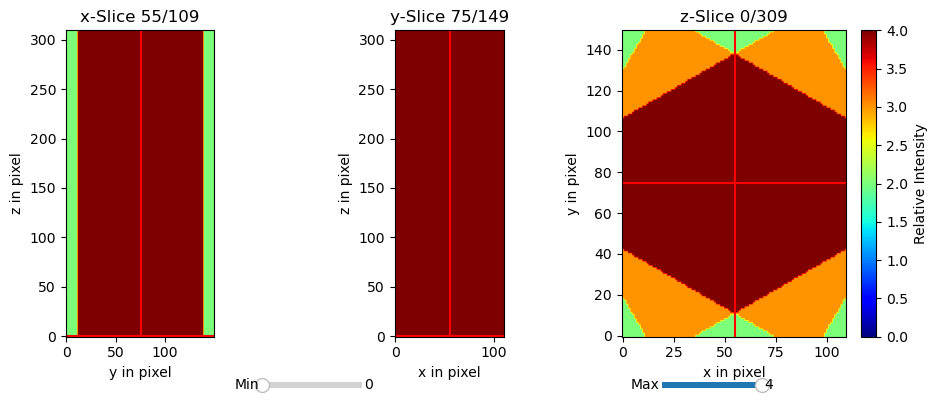

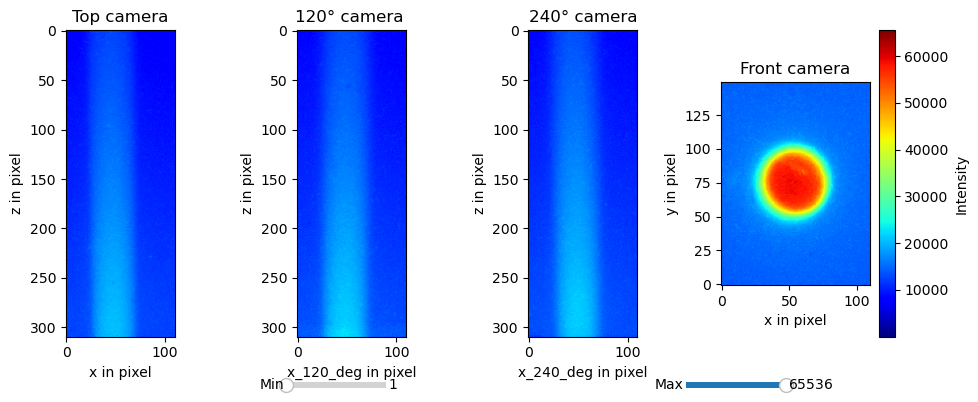

In [6]:
correction_matrix = Correction_matrix_producer(
    shape_front,
    shape_side,
    shift_image_top,
    shift_image_120,
    shift_image_240,
    shift_image_front,
    device,
).correction_matrix

Tomograpic_viewer(correction_matrix, False, 4)

save_directory = "../pictures/online/output/" + picture_name[:-4] + "/"
if not os.path.exists(save_directory):
    # Create a new directory because it does not exist
    os.makedirs(save_directory)

# Backgroung subtraction
smin = torch.tensor([torch.min(cam_pic_front),
                     torch.min(cam_pic_top),
                     torch.min(cam_pic_120),
                     torch.min(cam_pic_240)])
smin = torch.min(smin)
smin = 0
cam_pic_front[cam_pic_front < smin] = 0
cam_pic_top[cam_pic_top < smin] = 0
cam_pic_120[cam_pic_120 < smin] = 0
cam_pic_240[cam_pic_240 < smin] = 0
Camera_picture_viewer(cam_pic_front, cam_pic_top, cam_pic_120, cam_pic_240,
                      False, 16)

Iteration  1  done!
Iteration  2  done!
Iteration  3  done!
Iteration  4  done!
Quotient front:  [108.239990234375, 0.9346038699150085, 0.8489667177200317, 0.8153102993965149]
Quotient top:  [92.76377868652344, 0.9706591367721558, 0.951985239982605, 0.9438748359680176]
Quotient 120:  [116.13089752197266, 1.1895208358764648, 1.1542633771896362, 1.1389834880828857]
Quotient 240:  [118.16590118408203, 1.2112109661102295, 1.1757441759109497, 1.1602933406829834]


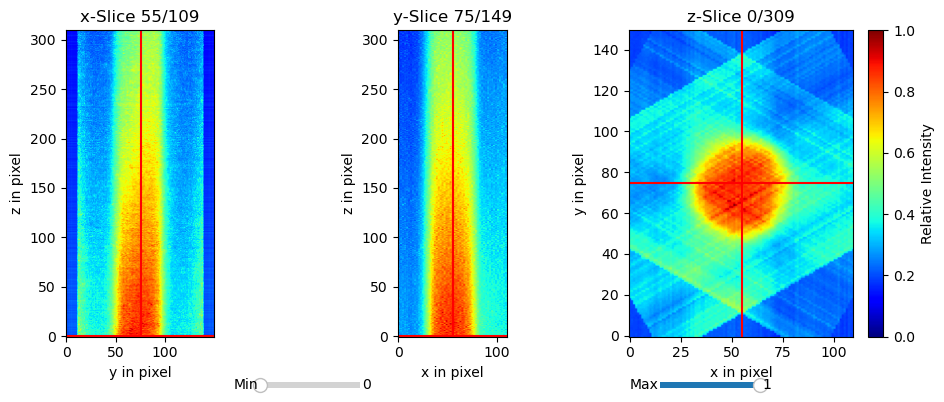

In [7]:
# %% ####################################Reconstruction
reconstructor = Reconstructor(
    max_it,
    max_err,
    cam_pic_front,
    cam_pic_top,
    cam_pic_120,
    cam_pic_240,
    correction_matrix,
    False,
    device,
)  # the last one is the median filter

reconstructor.perform_MLEM()
rec_light_dist = reconstructor.rec_light_dist

# save_name = "rec_light_dist_" + picture_name[:-4]
# np.save(save_directory + save_name, rec_light_dist.cpu().numpy())

# Saving itk file for 3D slicer
image = itk.GetImageFromArray(np.flip(rec_light_dist.cpu().numpy(), axis = 1))
image.SetSpacing([s, s, s])
itk.imwrite(image, save_directory+"rec_light_dist" + picture_name[:-4] + ".nrrd")

# Show reconstruction
Tomograpic_viewer(
    (rec_light_dist / rec_light_dist.max()), False, 1
)  # here you can enable the logaritmic scale

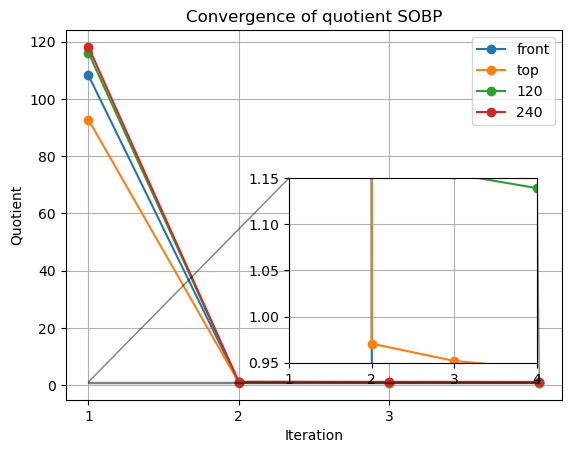

In [19]:
##### Calculate Error ########
# rec_light_dist = rec_light_dist.cpu().numpy()

def calculate_center_mean_per_slice(arr, radius):
    center = np.array(arr.shape) // 2
    # Initialize an array to store the mean values per slice
    mean_values_per_slice = np.zeros(arr.shape[0])
    mean_std_per_slice = np.zeros(arr.shape[0])

    for i in range(arr.shape[0]):
        # Create a meshgrid of indices for the current slice
        y, x = np.ogrid[: arr.shape[1], : arr.shape[2]]

        # Calculate the distance of each point from the center
        distance = np.sqrt((x - center[2]) ** 2 + (y - center[1]) ** 2)

        # Create a mask for points within the specified radius
        mask = distance <= radius

        # Extract values within the circular region for each slice
        circular_region = arr[i, mask]

        # Calculate the mean and standard deviation of the circular region for this slice
        mean_values_per_slice[i] = np.mean(circular_region)
        # mean_std_per_slice[i] = np.std(circular_region)/np.sqrt(len(circular_region))
        mean_std_per_slice[i] = np.std(circular_region)
    return mean_values_per_slice, mean_std_per_slice

mean_array, std = calculate_center_mean_per_slice(rec_light_dist,
                                                  int((ROI_diam/s)/2))
# reconstruction Error

q_front = np.array(reconstructor.quotient_front_ar)
q_top = np.array(reconstructor.quotient_top_ar)
q_120 = np.array(reconstructor.quotient_120_ar)
q_240 = np.array(reconstructor.quotient_240_ar)

q_err_rel = abs(((q_front[-1] + q_top[-1] + q_120[-1] + q_240[-1]) / 4) - 1)
q_err = np.zeros((deltaz))
for i in range(0, len(mean_array)):
    q_err[i] = mean_array[i] * q_err_rel
# calculate together with std

err_abs = np.zeros((deltaz))
for i in range(0, len(mean_array)):
    err_abs[i] = np.sqrt((q_err[i] ** 2) + (std[i] ** 2))

# Plot Error
major_ticks = np.arange(1, 4, 1)
ite = np.arange(1, len(q_front) + 1)
fig, ax = plt.subplots()
ax.plot(ite, q_front, marker="o", label="front")
ax.plot(ite, q_top, marker="o", label="top")
ax.plot(ite, q_120, marker="o", label="120")
ax.plot(ite, q_240, marker="o", label="240")
axins = ax.inset_axes([0.45, 0.1, 0.5, 0.5])
x1, x2, y1, y2 = 1, 4, 0.95, 1.15
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.plot(ite, q_front, marker="o", label="front")
axins.plot(ite, q_top, marker="o", label="top")
axins.plot(ite, q_120, marker="o", label="120")
axins.plot(ite, q_240, marker="o", label="240")
axins.grid(True)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xticks(major_ticks)
ax.set_title("Convergence of quotient SOBP")
ax.set_xlabel("Iteration")
ax.set_ylabel("Quotient")
ax.legend()
ax.grid(True)

plt.show()